In [16]:
#Importing Libraries for ML

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import warnings
warnings.filterwarnings("ignore")

In [34]:
# Importing Data
df = pd.read_csv('heart_disease_prediction.csv')
df.head(5)

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,Male,4.0,130.0,322.0,0,Cat - 2,109.0,0.0,2.4,2.0,3,3,Presence
1,67,Female,3.0,115.0,564.0,0,Cat - 2,160.0,0.0,1.6,2.0,0,7,Absence
2,57,Male,2.0,124.0,261.0,0,Cat - 0,141.0,0.0,0.3,1.0,0,7,Presence
3,64,Male,4.0,128.0,263.0,0,Cat - 0,105.0,1.0,0.2,2.0,1,7,Absence
4,74,Female,2.0,120.0,269.0,0,Cat - 2,121.0,1.0,0.2,1.0,1,3,Absence


In [35]:
# describe the data
df.describe()

,Age,Chest pain type,BP,Cholesterol,FBS over 120,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
count,270.000000,269.000000,267.000000,267.000000,270.000000,269.000000,269.000000,270.00000,266.000000,270.000000,270.000000
mean,54.433333,3.171004,131.546816,249.692884,0.148148,149.795539,0.330855,1.05000,1.582707,0.670370,4.696296
std,9.109067,0.950518,17.809578,51.925801,0.355906,23.127789,0.471398,1.14521,0.616382,0.943896,1.940659
min,29.000000,1.000000,94.000000,126.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000
25%,48.000000,3.000000,120.000000,212.500000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000
50%,55.000000,3.000000,130.000000,245.000000,0.000000,154.000000,0.000000,0.80000,2.000000,0.000000,3.000000
75%,61.000000,4.000000,140.000000,281.500000,0.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000
max,77.000000,4.000000,200.000000,564.000000,1.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000


### 1. Categorical Data Handling

In [36]:
# As Sex and Heart disease columns have binary data we will use one Binary hot encoding method
df_cat_handled = pd.get_dummies(df, columns=["Sex", "Heart Disease"], drop_first=True)

In [37]:
# As EKG results columns have kind of ordinar data we will impute the column with Ordinal data encoding
df_cat_handled["EKG results"].unique()

array(['Cat - 2', 'Cat - 0', 'Cat - 1', nan], dtype=object)

In [38]:
dic_impute = {'Cat - 0':1, 'Cat - 1':2, 'Cat - 2':3}

In [39]:
df_cat_handled["EKG results"] = df_cat_handled["EKG results"].map(dic_impute)
df_cat_handled.head()

,Age,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Sex_Male,Heart Disease_Presence
0,70,4.0,130.0,322.0,0,3.0,109.0,0.0,2.4,2.0,3,3,1,1
1,67,3.0,115.0,564.0,0,3.0,160.0,0.0,1.6,2.0,0,7,0,0
2,57,2.0,124.0,261.0,0,1.0,141.0,0.0,0.3,1.0,0,7,1,1
3,64,4.0,128.0,263.0,0,1.0,105.0,1.0,0.2,2.0,1,7,1,0
4,74,2.0,120.0,269.0,0,3.0,121.0,1.0,0.2,1.0,1,3,0,0


### 2. Missing Values Handling

In [40]:
class missing_values_handler():
    
    def __init__(self, df):
        self.df = df
        self.nulls_in_row_df = None
        self.deleted_rows_df = None
        
        self.null_in_col_df = None
        self.deleted_cols_df = None
        
    def find_columnwise_na(self):
        """
        Find out the columns and respective null value ounts and its percentage with respect to total number of records.
        """
        # creating the data frame with column name and respective null count
        null_in_col_df = self.df.isnull().sum()
        null_in_col_df = pd.DataFrame({"Columns Name":null_in_col_df.index, "Number of NA in Column":list(null_in_col_df)})
        null_in_col_df["Percentage"] = round(null_in_col_df["Number of NA in Column"]*100/len(self.df), 2)
        
        # sorting the data frame
        null_in_col_df = null_in_col_df.sort_values("Number of NA in Column", ascending=False)
        
        # saving the data
        self.null_in_col_df = null_in_col_df
        return null_in_col_df
    
    
    def delete_cols_above_threashold_na(self, threashold, inplace):
        """
        Find the columns in dataframe with na count higher than threashold and delete them
        """
        # create dataframe with cols and na count
        self.find_columnwise_na()
        
        # find the columns having higher count than threashold
        cols = list(self.null_in_col_df[self.null_in_col_df["Percentage"]>threashold]["Columns Name"])
        
        # delete the columns
        deleted_cols_df = self.df.drop(cols, axis=1)
        
        # saving data
        self.deleted_cols_df = deleted_cols_df
        if inplace:
            self.df = deleted_cols_df
            
        return deleted_cols_df
        
    # Lets findout the rows having maximum number of columns with NA value
    def find_rowwise_na(self):
        """
        Find out the number of columns having NA values for a rows, so that rows having more number of NA valued columns can be deleted.
        """

        df_isnull = self.df.isnull()
        nulls_in_row_dict = {}

        # calculate the number of columns having null value
        for index, row in df_isnull.iterrows():
            nulls_in_row_dict[index] = sum(row)

        # form a dataframe
        nulls_in_row_df = pd.DataFrame({"Row number": nulls_in_row_dict.keys(), 
                                        "Number of columns having NA": nulls_in_row_dict.values()}, index=None)

        # find percentage of columns having 0 value for given rows and sort
        nulls_in_row_df["Percentage"] =  round(nulls_in_row_df["Number of columns having NA"]/len(df_isnull.columns), 2)*100
        nulls_in_row_df = nulls_in_row_df.sort_values("Number of columns having NA", ascending=False)
        
        self.nulls_in_row_df = nulls_in_row_df
        return nulls_in_row_df
    
    
    
    # delete the rows based on the given number of threashold percentage, row will be deleted for which number of columns having missing values is higher than given threashold value 
    def delete_rows_above_threashold_na(self, threashold, inplace):
        """
        Delete the rows having more number of NA values than specified threashold
        """
        # find rows above threashold number of na
        rows_numbers = self.nulls_in_row_df[self.nulls_in_row_df["Percentage"]>threashold]["Row number"]
        rows_numbers = list(rows_numbers)
        
        # delete the rows
        deleted_rows_df = self.df.drop(index=rows_numbers)
        
        # save changes
        self.deleted_rows_df = deleted_rows_df
        
        if inplace:
            self.df = deleted_rows_df
            
        return deleted_rows_df
    
    
    
    
missing_handler = missing_values_handler(df)

<Axes: >

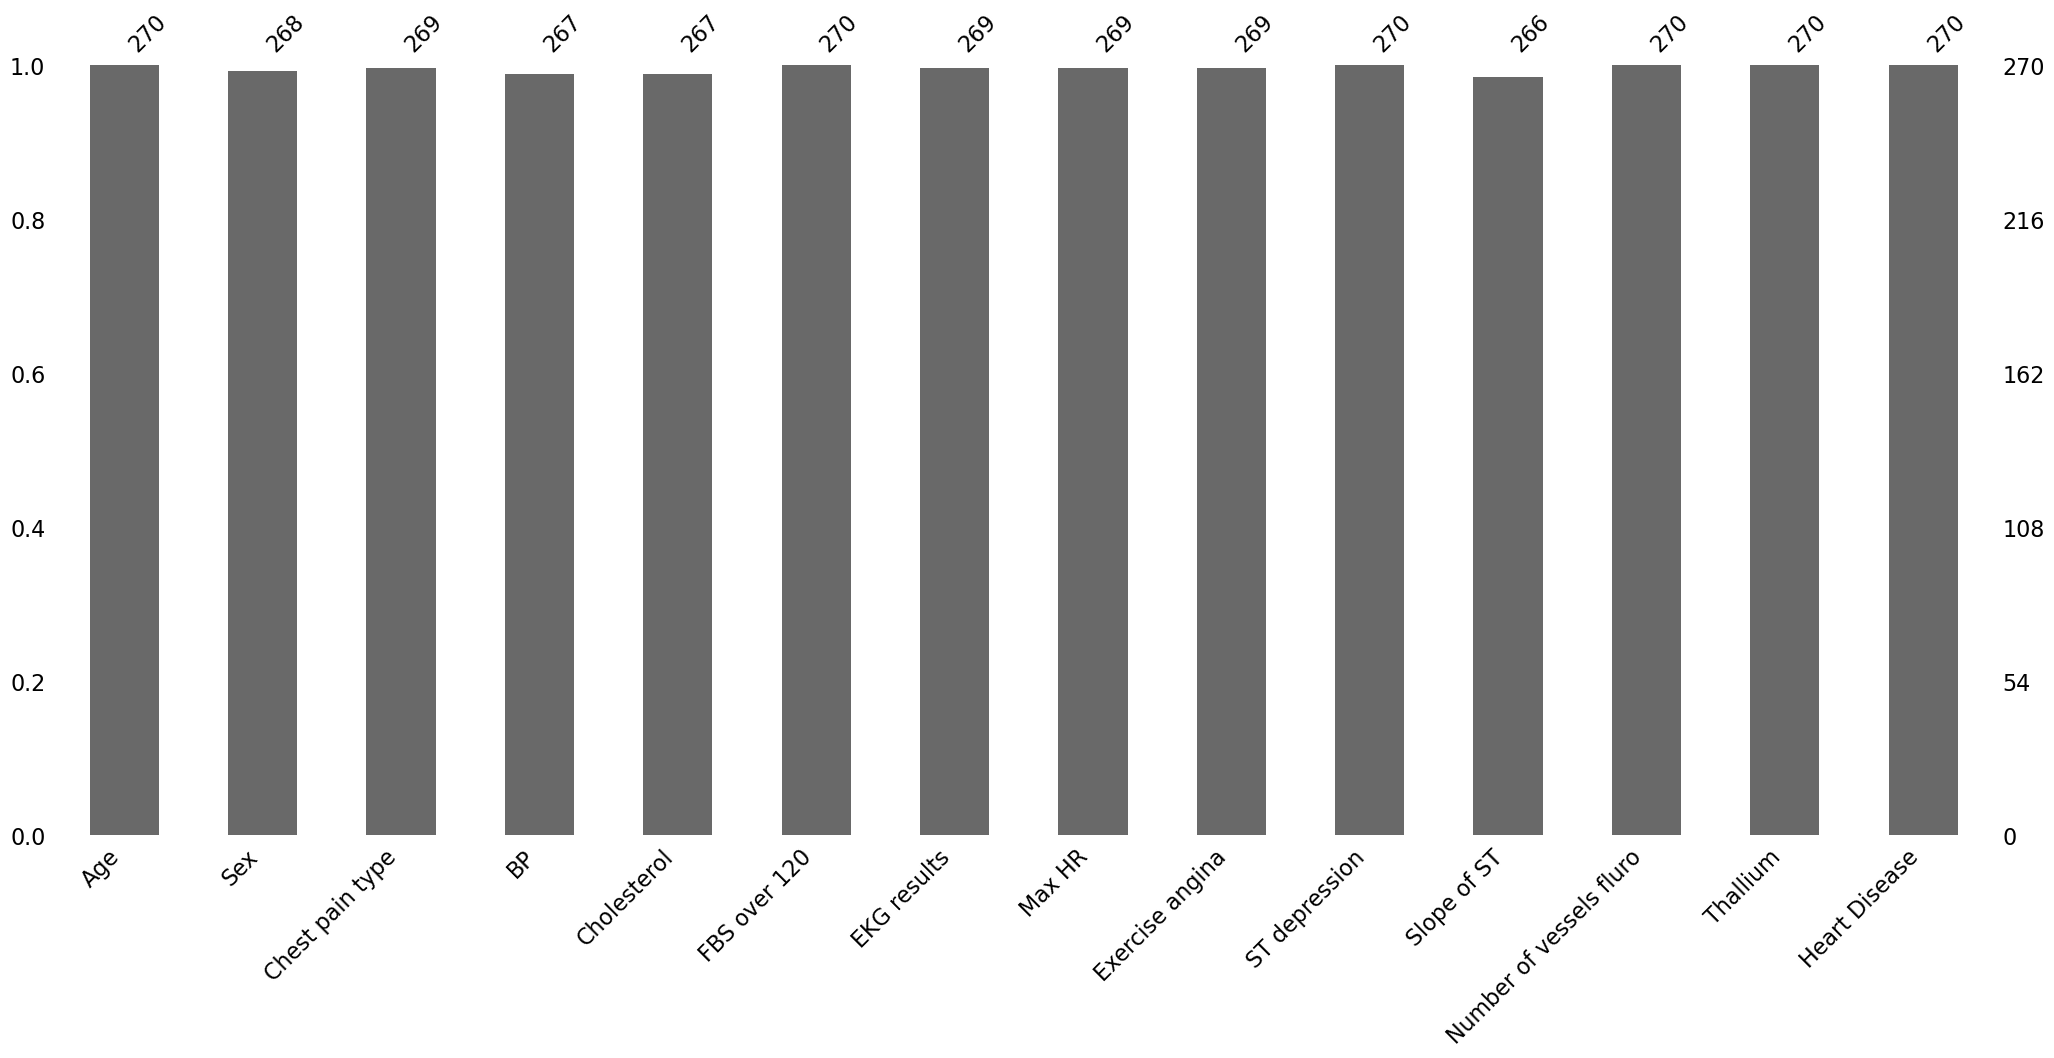

In [41]:
msno.bar(df)

Sex, chest pain, Bp, cholesterol, EKG results, Max HR, Exercise angina, slope of ST columns have missing values 

<Axes: >

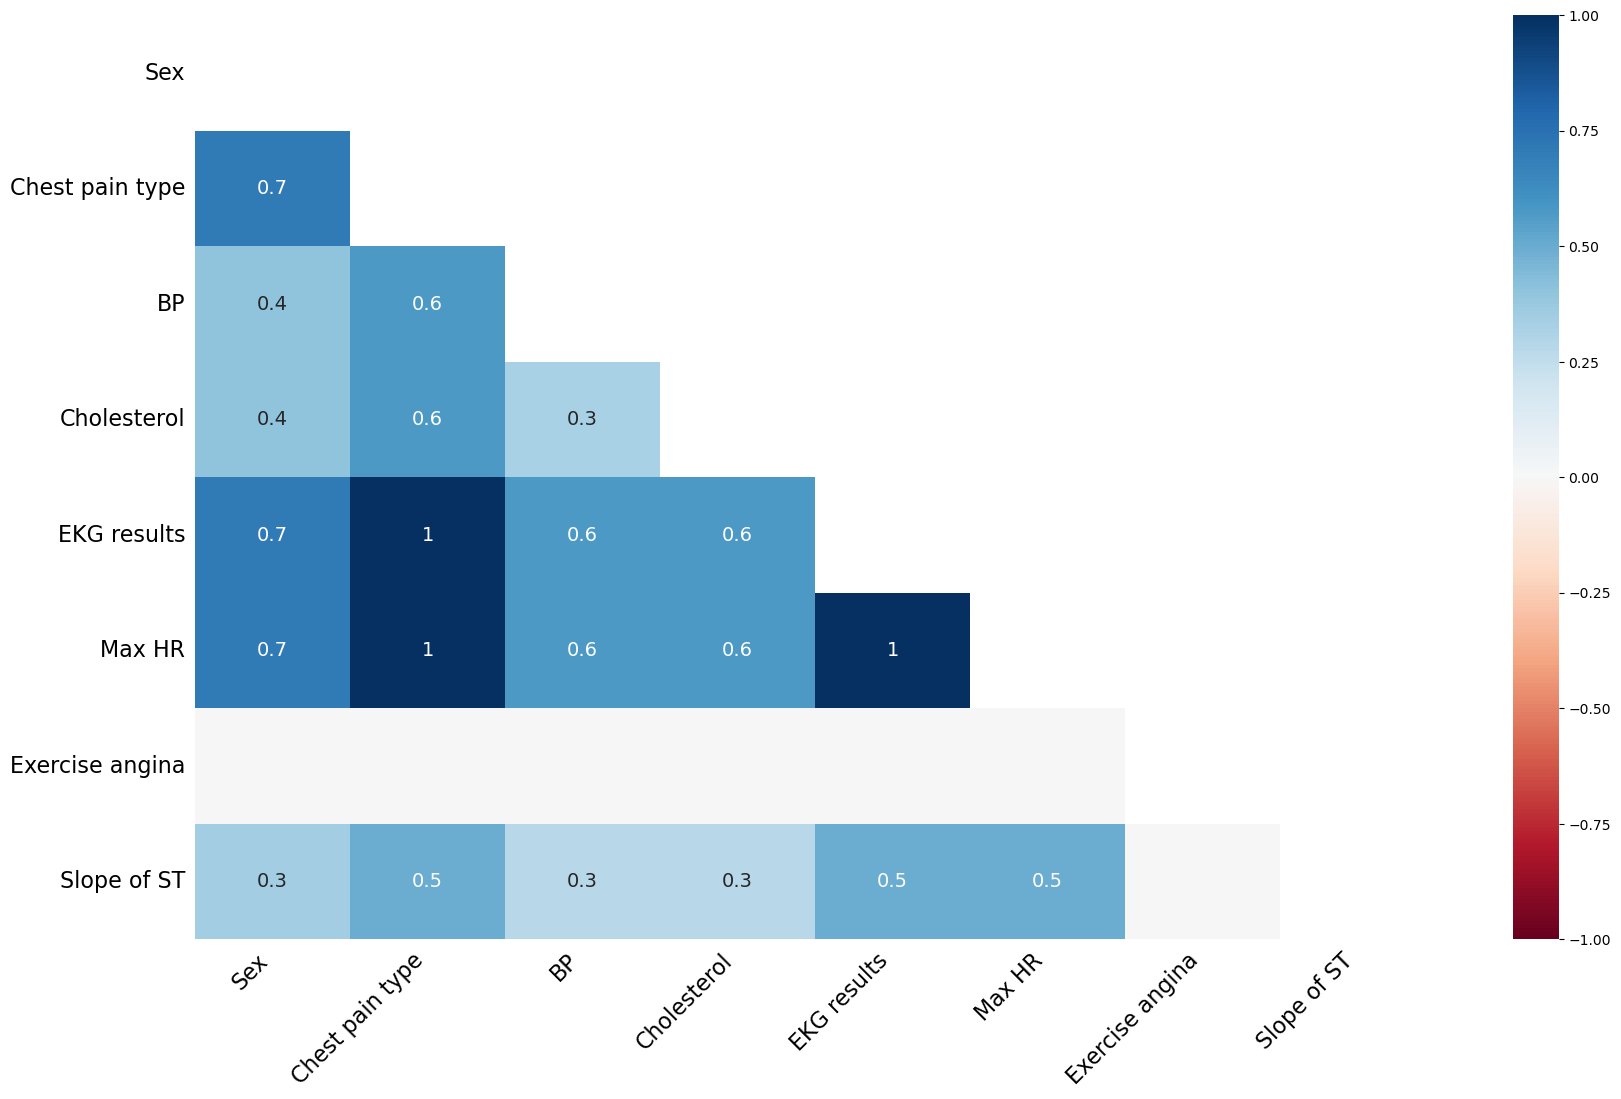

In [42]:
msno.heatmap(df)

Presence or absence of one variable i.e. nullity of one variable affects another variables

Nullity of EKG results depends on Chest pain type
Nullity of Max HR depends on chest pain type
Nullity of EKG results depends on Max HR

Nullity of other columns like chest pain type, EKG rsults, Max HR also depends on Sex columns 

Nullity of Exercise angina does not depends upon any other variables

<Axes: >

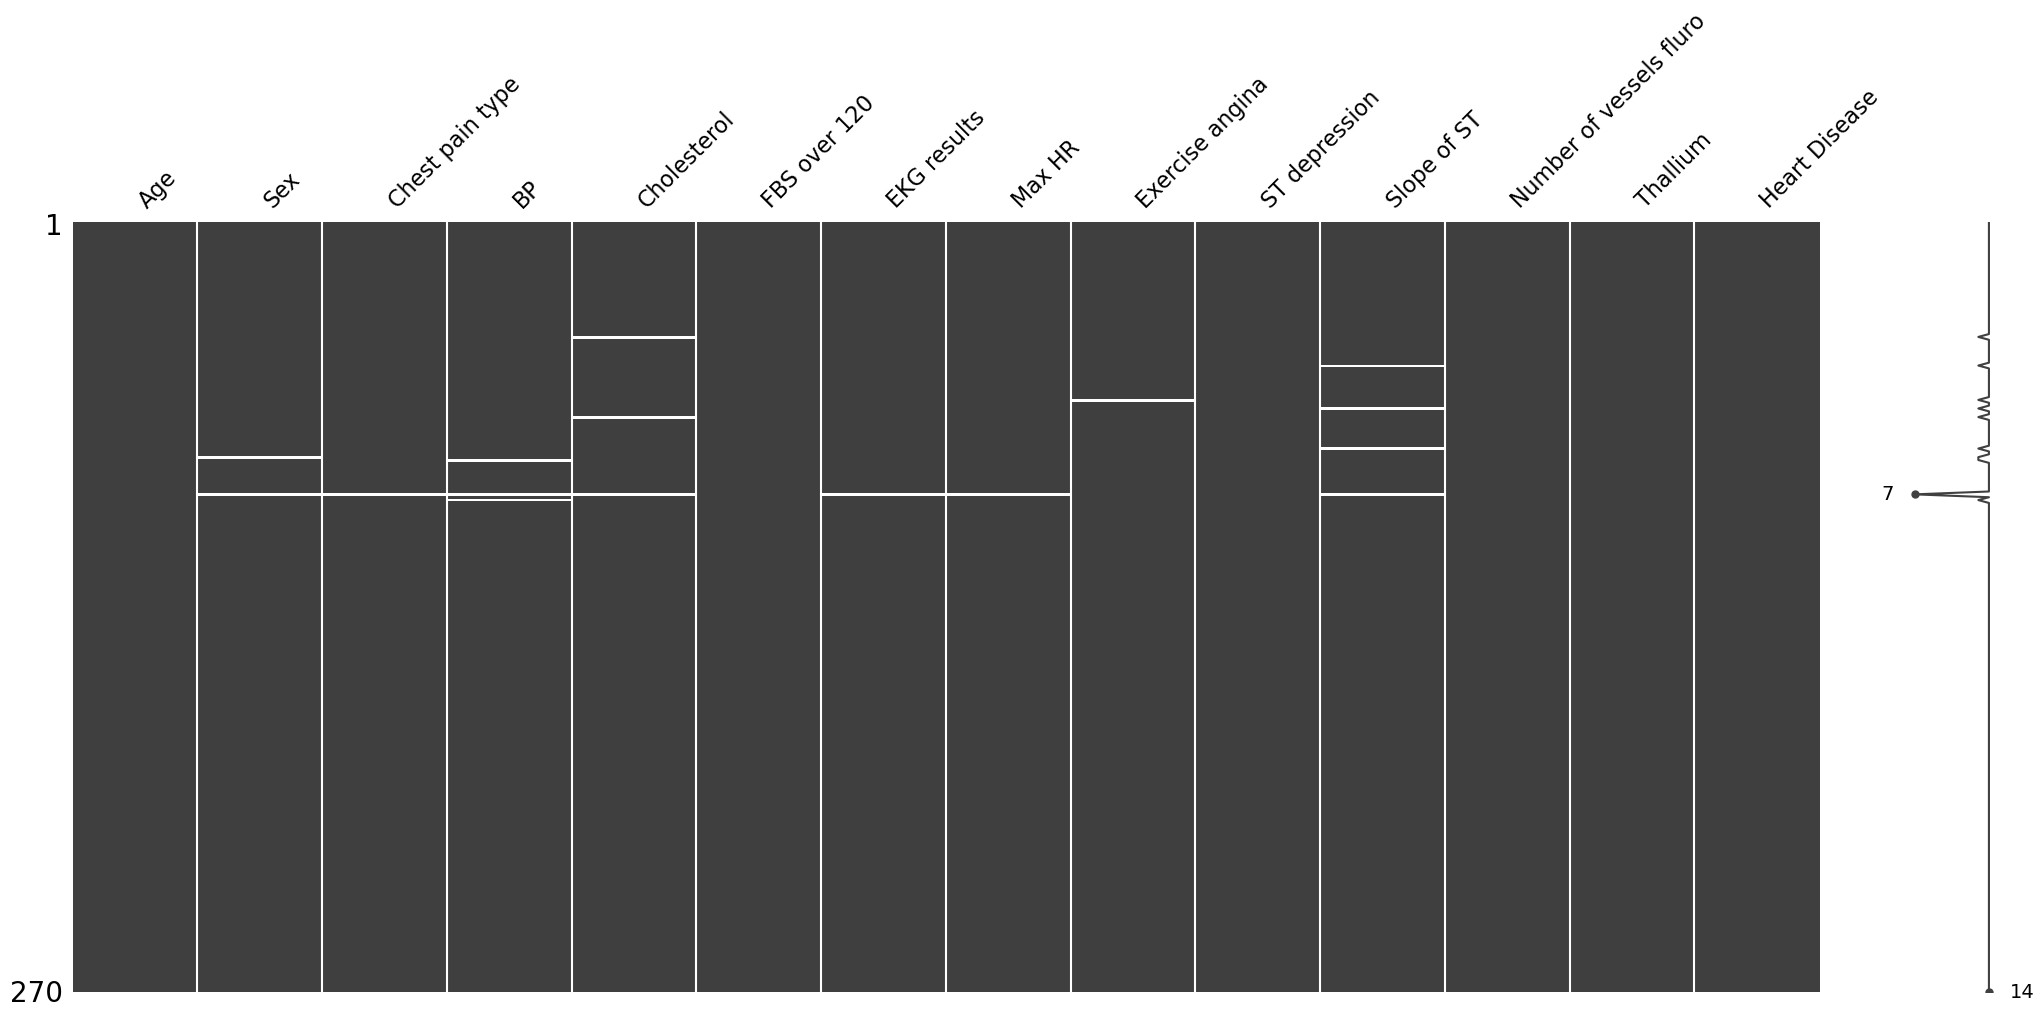

In [43]:
msno.matrix(df)

<Axes: >

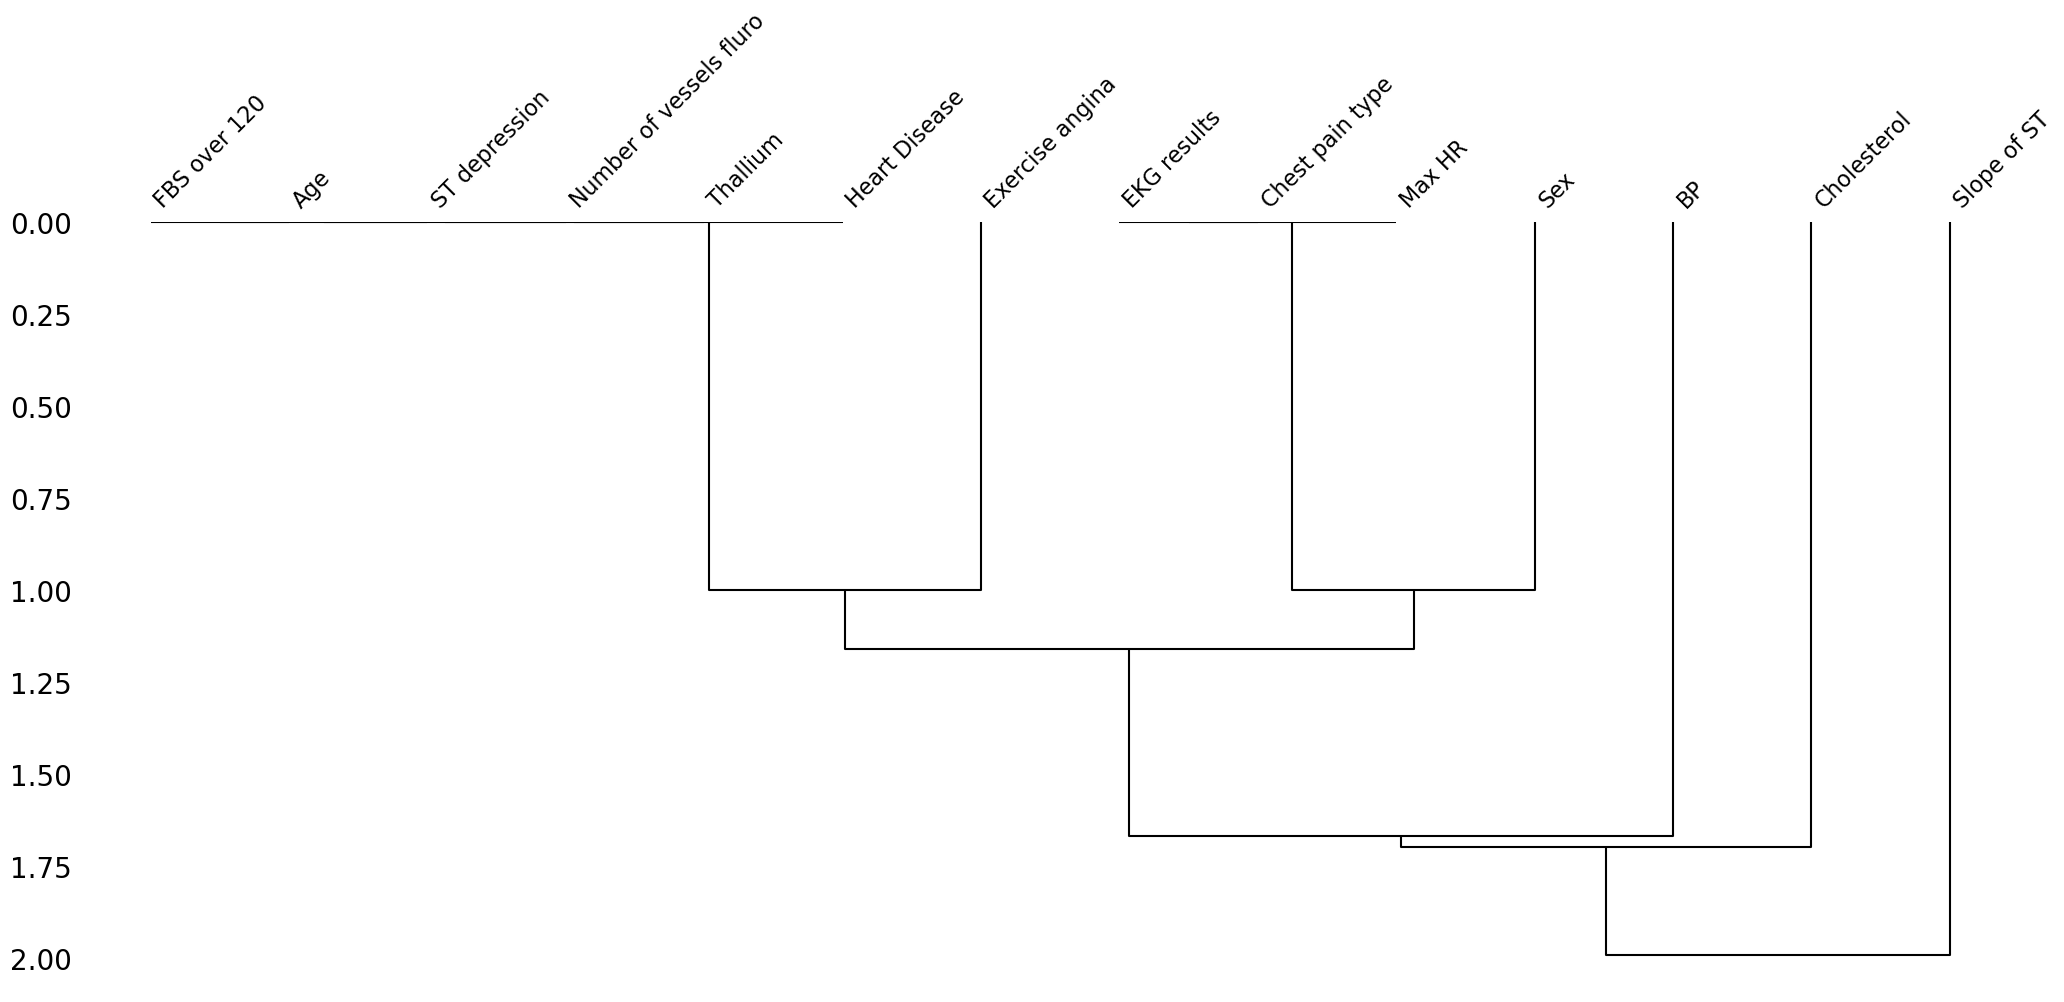

In [44]:
msno.dendrogram(df)